In [1]:
import sys
from argparse import Namespace
from pathlib import Path

import pytorch_lightning as pl
import torch
from torchvision import transforms
from torchvision.datasets import MNIST, EMNIST
from tqdm import trange

In [2]:
# Update path to import src code
sys.path.append("..")

In [3]:
from src import SplitNN, ConvAttackModel, plot_images, AttackDataset

In [4]:
project_root = Path.cwd().resolve().parent

In [5]:
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")

---
# 5. NoPeek
In this experiment
we investigate combining NoPeekNN with noise

## Load target model
Load a model trained without noise

In [6]:
noise = 1.0

In [7]:
model_path = (project_root / "models" / f"tanh_model_celoss_00nopeek_{noise}noise".replace(".", "")).with_suffix(".pth")
noiseless_model_path = project_root / "models" / "tanh_model_celoss_00nopeek.pth"

In [8]:
target_model = SplitNN(noise)

checkpoint = torch.load(model_path)
target_model.load_state_dict(checkpoint["model_state_dict"])

target_model = target_model.to(device)
target_model.eval()
target_model

SplitNN(
  (part1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten()
    (6): Linear(in_features=9216, out_features=500, bias=True)
    (7): Tanh()
  )
  (part2): Sequential(
    (0): Linear(in_features=500, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
    (3): Softmax(dim=1)
  )
)

## Evaluate model

In [9]:
data_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ]
)

In [10]:
mnist_train = MNIST(project_root / "data", download=True, train=True, transform=data_transform)
mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=256)

## Confirm target model performance

In [11]:
mnist_test = MNIST(project_root / "data", download=True, train=False, transform=data_transform)
mnist_test.data = mnist_test.data[:5_000]
mnist_test.targets = mnist_test.targets[:5_000]

mnist_test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1000)

In [12]:
target_test_correct = 0
target_test_total = 0

target_model.eval()
for data, targets in mnist_test_loader:
    data = data.to(device)
    targets = targets.to(device)

    with torch.no_grad():
        outputs, _ = target_model(data)

    target_test_correct += outputs.max(1)[1].eq(targets).sum().item()
    target_test_total += outputs.size(0)

target_test_accuracy = 100 * target_test_correct / target_test_total
print(f"Target model accuracy: {target_test_accuracy:.3f}")

Target model accuracy: 97.520


## Compare to noiseless model
How does adding this noise compare to noiseless model?

In [13]:
noiseless_model = SplitNN(0.0)

checkpoint = torch.load(noiseless_model_path)
noiseless_model.load_state_dict(checkpoint["model_state_dict"])

noiseless_model = noiseless_model.to(device)
noiseless_model.eval()

SplitNN(
  (part1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten()
    (6): Linear(in_features=9216, out_features=500, bias=True)
    (7): Tanh()
  )
  (part2): Sequential(
    (0): Linear(in_features=500, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
    (3): Softmax(dim=1)
  )
)

In [14]:
noiseless_test_correct = 0
noiseless_test_total = 0

for data, targets in mnist_test_loader:
    data = data.to(device)
    targets = targets.to(device)

    with torch.no_grad():
        outputs, _ = noiseless_model(data)

    noiseless_test_correct += outputs.max(1)[1].eq(targets).sum().item()
    noiseless_test_total += outputs.size(0)

noiseless_test_accuracy = 100 * noiseless_test_correct / noiseless_test_total
print(f"Noiseless model accuracy: {noiseless_test_accuracy:.3f}")

Noiseless model accuracy: 98.420


## Attack network
We will train the attack model on EMNIST images.
These are similar enough to MNIST for the attack to work in principle,
but different enough to simulate a real-world attack setting (unknown training data).

In [26]:
attacker_hparams = Namespace(learning_rate=1e-4, max_epochs=10, batch_size=32)

## Create attacker datasets

In [15]:
emnist_train = EMNIST(project_root / "data", "letters", download=True, train=True, transform=data_transform)
emnist_train.data = emnist_train.data[: 2_000]
emnist_train.targets = emnist_train.targets[: 2_000]

emnist_val = EMNIST(project_root / "data", "letters", download=True, train=False, transform=data_transform)
emnist_val.data = emnist_val.data[: 2_000]
emnist_val.targets = emnist_val.targets[: 2_000]

emnist_trainloader = torch.utils.data.DataLoader(emnist_train, batch_size=128)
emnist_valloader = torch.utils.data.DataLoader(emnist_val, batch_size=128)

### noisy model dataset

In [27]:
attack_train = AttackDataset()
attack_val = AttackDataset()

# Train data
for data, _ in emnist_trainloader:
        data = data.to(device)

        # Get target model output
        with torch.no_grad():
            _, intermediate_data = target_model(data)

        attack_train.push(intermediate_data, data)

# Validation data
for data, _ in emnist_valloader:
        data = data.to(device)

        # Get target model output
        with torch.no_grad():
            _, intermediate_data = target_model(data)

        attack_val.push(intermediate_data, data)

attack_trainloader = torch.utils.data.DataLoader(attack_train, batch_size=128)
attack_valloader = torch.utils.data.DataLoader(attack_val, batch_size=128)

### noiseless model dataset

In [28]:
noiseless_attack_train = AttackDataset()
noiseless_attack_val = AttackDataset()

# Train data
for data, _ in emnist_trainloader:
        data = data.to(device)

        # Get target model output
        with torch.no_grad():
            _, intermediate_data = noiseless_model(data)

        noiseless_attack_train.push(intermediate_data, data)

# Validation data
for data, _ in emnist_valloader:
        data = data.to(device)

        # Get target model output
        with torch.no_grad():
            _, intermediate_data = noiseless_model(data)

        noiseless_attack_val.push(intermediate_data, data)

noiseless_attack_trainloader = torch.utils.data.DataLoader(noiseless_attack_train, batch_size=128)
noiseless_attack_valloader = torch.utils.data.DataLoader(noiseless_attack_val, batch_size=128)

## Train attack models

In [29]:
attack_model = ConvAttackModel(attacker_hparams).to(device)

attack_trainer = pl.Trainer(max_epochs=attacker_hparams.max_epochs)
attack_trainer.fit(attack_model, attack_trainloader, attack_valloader)
attack_trainer.test(attack_model, test_dataloaders=attack_valloader)

GPU available: False, used: False
No environment variable for node rank defined. Set as 0.

  | Name     | Type            | Params
-----------------------------------------
0 | linear1  | Linear          | 4 M   
1 | layers   | Sequential      | 57 K  
2 | layers.0 | ConvTranspose2d | 36 K  
3 | layers.1 | ConvTranspose2d | 18 K  
4 | layers.2 | ConvTranspose2d | 2 K   
5 | layers.3 | ConvTranspose2d | 73    


--------------------------------------------------------------------------------
TEST RESULTS
{'avg_test_loss': tensor(0.3555), 'test_loss': tensor(0.3555)}
--------------------------------------------------------------------------------



## Train attacker on noiseless model

In [30]:
noiseless_attack_model = ConvAttackModel(attacker_hparams).to(device)
noiseless_attack_trainer = pl.Trainer(max_epochs=attacker_hparams.max_epochs)
noiseless_attack_trainer.fit(noiseless_attack_model, noiseless_attack_trainloader, noiseless_attack_valloader)
noiseless_attack_trainer.test(noiseless_attack_model, test_dataloaders=noiseless_attack_valloader)

GPU available: False, used: False
No environment variable for node rank defined. Set as 0.

  | Name     | Type            | Params
-----------------------------------------
0 | linear1  | Linear          | 4 M   
1 | layers   | Sequential      | 57 K  
2 | layers.0 | ConvTranspose2d | 36 K  
3 | layers.1 | ConvTranspose2d | 18 K  
4 | layers.2 | ConvTranspose2d | 2 K   
5 | layers.3 | ConvTranspose2d | 73    


--------------------------------------------------------------------------------
TEST RESULTS
{'avg_test_loss': tensor(0.3493), 'test_loss': tensor(0.3493)}
--------------------------------------------------------------------------------



## Visualise reconstruction

In [31]:
mnist_test = MNIST(project_root / "data", download=True, train=False, transform=data_transform)
mnist_test.data = mnist_test.data[5_000:]
mnist_test.targets = mnist_test.targets[5_000:]

### Noisy model

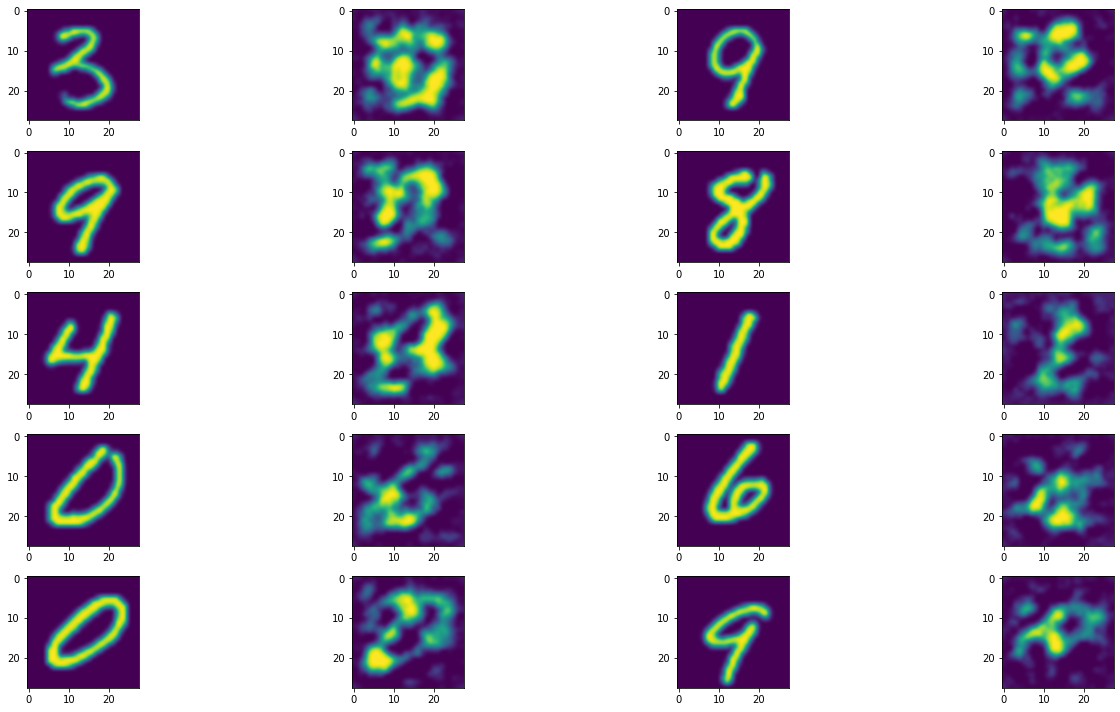

In [32]:
ims = []

for i in range(10):
    image, _ = mnist_test[i]

    with torch.no_grad():
        intermediate = target_model.encode(image.unsqueeze(0))
        reconstructed = attack_model(intermediate)

    reconstructed = reconstructed.squeeze(0)
    ims.extend([image, reconstructed])

plot_images(ims)

### Compare noisy and noiseless models

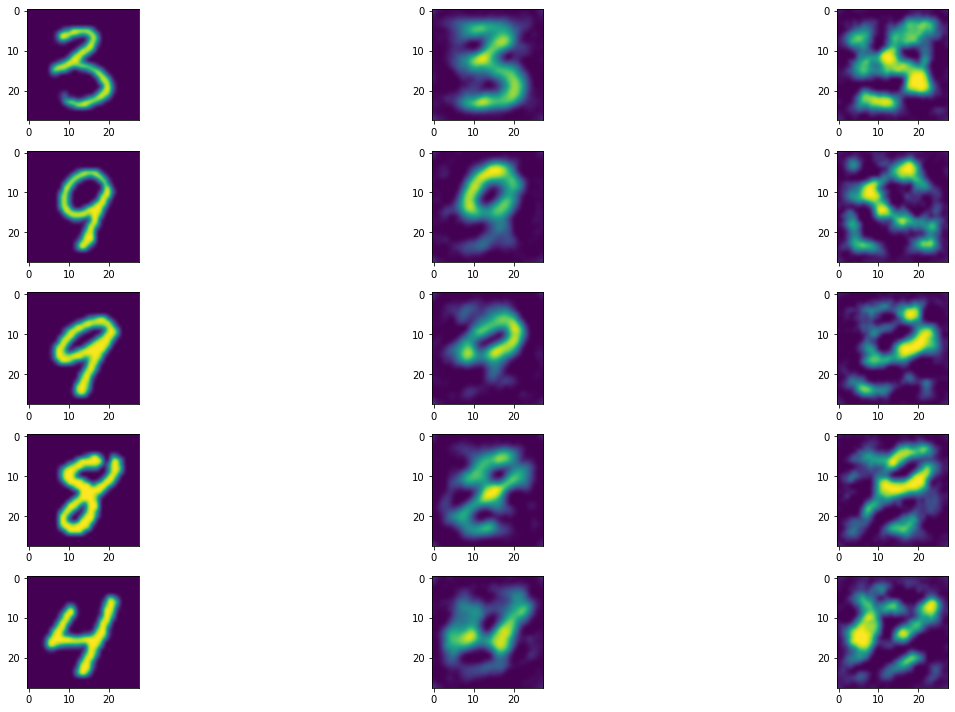

In [33]:
ims = []

for i in range(5):
    image, _ = mnist_test[i]

    with torch.no_grad():
        intermediate = target_model.encode(image.unsqueeze(0))
        reconstructed = attack_model(intermediate)

        intermediate_noiseless = noiseless_model.encode(image.unsqueeze(0))
        reconstructed_noiseless = noiseless_attack_model(intermediate_noiseless) 

    reconstructed = reconstructed.squeeze(0)
    reconstructed_noiseless = reconstructed_noiseless.squeeze(0)
    ims.extend([image, reconstructed_noiseless, reconstructed])

plot_images(ims, rows=5, cols=3)